In [1]:
from huggingface_hub import notebook_login
 
notebook_login()

In [1]:
import json
import os
import warnings

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from peft import PeftConfig, PeftModel

from utils import save_conversation, load_conversation

from fastchat.utils import get_gpu_memory, is_partial_stop, is_sentence_complete, get_context_length
from fastchat.conversation import get_conv_template, register_conv_template, Conversation, SeparatorStyle
from fastchat.serve.inference import generate_stream

warnings.filterwarnings('ignore')

[2023-11-27 02:17:05,837] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
SYSTEM_MSG = """Your name is Zen and you're a mental health counselor. Please have a conversation with your patient and provide them with a helpful response to their concerns."""

try:
    register_conv_template(
        Conversation(
            name="Zen",
            system_message=SYSTEM_MSG,
            roles=("USER", "ASSISTANT"),
            sep_style=SeparatorStyle.ADD_COLON_TWO,
            sep=" ",
            sep2="</s>",
        )
    )
except AssertionError:
    pass

In [3]:
def load_model(model_path, num_gpus, base_model_path=None, max_gpu_memory=None):
    
    kwargs = {"torch_dtype": torch.float16}
    if num_gpus != 1:
        kwargs["device_map"] = "auto"
        if max_gpu_memory is None:
            kwargs[
                "device_map"
            ] = "sequential"  # This is important for not the same VRAM sizes
            available_gpu_memory = get_gpu_memory(num_gpus)
            kwargs["max_memory"] = {
                i: str(int(available_gpu_memory[i] * 0.85)) + "GiB"
                for i in range(num_gpus)
            }
        else:
            kwargs["max_memory"] = {i: max_gpu_memory for i in range(num_gpus)}
        
        if base_model_path is None:
            config = PeftConfig.from_pretrained(model_path)
            base_model_path = config.base_model_name_or_path
            
        tokenizer = AutoTokenizer.from_pretrained(
            base_model_path, use_fast=False
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_path,
            low_cpu_mem_usage=True,
            **kwargs,
        )
        if base_model_path is None:
            model = PeftModel.from_pretrained(model, model_path)
        
        return model, tokenizer

In [4]:
import pandas as pd
import pickle
import re

from tqdm.notebook import tqdm

df_path = "/home/jupyter/therapy-bot/data/processed/llm_responses.csv"
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    with open("/home/jupyter/therapy-bot/train/v2/test.p", "rb") as f:
        test = pickle.load(f)

    df = pd.DataFrame(columns=["orig_prompt"], data=test)
    df["answer"] = df.orig_prompt.apply(lambda x: re.findall(r'ASSISTANT: (.*?)</s>', x, re.DOTALL)[-1].strip())
    df.to_csv(df_path, index=False)
    
df.head()

,orig_prompt,answer,llama-2,vicuna_v1.1
0,Your name is Zen and you're a mental health co...,There are a few things you can try to help wit...,"[FONT=Verdana, Arial, Helvetica]\n\n[FONT=Verd...",I see. It can be very frustrating when you're ...
1,Your name is Zen and you're a mental health co...,It's important to establish a bedtime routine ...,[Docs] Insomnia: a condition in which you find...,It's common for people to experience difficult...
2,Your name is Zen and you're a mental health co...,"No, I am a AI mental health counseling chatbot...",[/INST]\n\n[HINT]\n[HINTP]\n[HINT]\n[HINTP]\n[...,"No, I'm a language model developed by research..."
3,Your name is Zen and you're a mental health co...,It's important to be patient and kind to yours...,[INST] It's possible that you're feeling frust...,I understand that feeling frustrated with ther...
4,Your name is Zen and you're a mental health co...,Sleep hygiene is important for getting a good ...,"<img src=""https://i.imgur.com/JrXWb2A.jpg"" wid...",I see. Trouble sleeping can be caused by vario...


In [5]:
def get_conv(text, conv_template):
    conv = get_conv_template(conv_template)
    conv.messages = []
    conv.set_system_message(SYSTEM_MSG)
    
    q = re.findall(r'USER: (.*?) ASSISTANT:', text, re.DOTALL)
    a = re.findall(r'ASSISTANT: (.*?)</s>', text, re.DOTALL)
    assert len(q) == len(a)
    
    conv.append_message(conv.roles[0], "Hello! I'm Manish!")
    conv.append_message(conv.roles[1], "Hello Manish! How can I help you today?")
    
    for i in range(len(q)):
        conv.append_message(conv.roles[0], q[i].strip())
        
        if i == len(q) - 1:
            conv.append_message(conv.roles[1], None)
        else:
            conv.append_message(conv.roles[1], a[i].strip())
    
    return conv

In [6]:
model_name = "Zen" # "llama-2", "vicuna_v1.1", "Zen"
num_gpus = 4
max_gpu_memory = "12GiB"

if model_name == "llama-2":
    model, tokenizer = load_model(model_path=None, num_gpus=num_gpus, base_model_path="meta-llama/Llama-2-13b-hf", max_gpu_memory=max_gpu_memory)
elif model_name == "vicuna_v1.1":
    model, tokenizer = load_model(model_path=None, num_gpus=num_gpus, base_model_path="lmsys/vicuna-13b-v1.5", max_gpu_memory=max_gpu_memory)
else:
    model_path = "/home/jupyter/therapy-bot/models/ZenAI"
    model, tokenizer = load_model(model_path=model_path, num_gpus=num_gpus, max_gpu_memory=max_gpu_memory)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
def ask_question(
    model, tokenizer, question,
    device, num_gpus, max_gpu_memory,
    conv_template,
    temperature, repetition_penalty, max_new_tokens,
    dtype=torch.float16,
    judge_sent_end=True
):
    context_len = get_context_length(model.config)
    
    def get_output(output_stream):
        pre = 0
        for outputs in output_stream:
            output_text = outputs["text"]
            output_text = output_text.strip().split(" ")
            now = len(output_text) - 1
            if now > pre:
                pre = now
        return " ".join(output_text)
    
    conv = get_conv(question, conv_template)
    prompt = conv.get_prompt()

    gen_params = {
        "prompt": prompt,
        "temperature": temperature,
        "repetition_penalty": repetition_penalty,
        "max_new_tokens": max_new_tokens,
        "stop": conv.stop_str,
        "stop_token_ids": conv.stop_token_ids,
        "echo": False,
    }

    output_stream = generate_stream(
        model,
        tokenizer,
        gen_params,
        device,
        context_len=context_len,
        judge_sent_end=judge_sent_end,
    )
    return get_output(output_stream)

In [8]:
for i in tqdm(range(len(df))):
    question = df.orig_prompt[i]
    answer = ask_question(
        model, tokenizer, question,
        device="cuda", num_gpus=4, max_gpu_memory="12GiB",
        conv_template=model_name, temperature=0.7,
        repetition_penalty=1.0, max_new_tokens=128
    )
    df.loc[i, model_name] = answer
    
    if (i + 1) % 10 == 0:
        df.to_csv(df_path, index=False)

df.to_csv(df_path, index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
import warnings
import pandas as pd

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

from rouge import Rouge
from bert_score import score


# nltk.download('punkt')
# nltk.download('wordnet')
warnings.filterwarnings('ignore')


def calculate_bleu(references, candidates):
    """
    Calculate BLEU score for two lists of strings.
    :param references: List of reference strings (ground truth).
    :param candidates: List of candidate strings (generated text).
    :return: BLEU score.
    """
    # Tokenize the sentences
    tokenized_references = [word_tokenize(ref.lower()) for ref in references]
    tokenized_candidates = [word_tokenize(candidate.lower()) for candidate in candidates]
    # Calculate BLEU score
    scores = [sentence_bleu([ref], cand) for ref, cand in zip(tokenized_references, tokenized_candidates)]
    score = round(sum(scores) * 100 / len(scores), 2)
    return score


def rouge_dict_to_dataframe(rouge_dict):
    """
    Convert a ROUGE scores dictionary to a pandas DataFrame.
    :param rouge_dict: Dictionary containing ROUGE scores.
    :return: DataFrame with the ROUGE scores.
    """
    # Initialize an empty dictionary to hold the data
    data = {}
    # Loop through each ROUGE type and extract the values
    for rouge_type, scores in rouge_dict.items():
        for score_type, value in scores.items():
            # Create a column name like 'rouge-1_r', 'rouge-1_p', etc.
            col_name = f'{rouge_type}_{score_type}'
            data[col_name] = [value*100]
    # Create and return the DataFrame
    return pd.DataFrame(data).round(2)


def calculate_rouge(references, candidates):
    """
    Calculate ROUGE score for two lists of strings.
    :param references: List of reference strings (ground truth).
    :param candidates: List of candidate strings (generated text).
    :return: Dictionary of ROUGE scores.
    """
    rouge = Rouge()
    scores = rouge.get_scores(candidates, references, avg=True)
    return scores


def calculate_meteor(references, candidates):
    """
    Calculate METEOR score for lists of reference and candidate strings.
    :param references: List of reference strings.
    :param candidates: List of candidate strings.
    :return: Average METEOR score.
    """
    # Tokenize the candidate sentences
    tokenized_references = [word_tokenize(ref.lower()) for ref in references]
    tokenized_candidates = [word_tokenize(cand.lower()) for cand in candidates]
    # Calculate METEOR score for each pair of reference and tokenized candidate
    scores = [meteor_score([ref], cand) for ref, cand in zip(tokenized_references, tokenized_candidates)]
    score = round(sum(scores) * 100 / len(scores), 2)
    return score


def calculate_bert_score(references, candidates):
    """
    Calculate BERTScore for lists of reference and candidate strings.
    :param references: List of reference strings.
    :param candidates: List of candidate strings.
    :return: Average BERTScore.
    """
    P, R, F1 = score(candidates, references, lang="en")
    P = round(P.mean().item() * 100, 2)
    R = round(R.mean().item() * 100, 2)
    F1 = round(F1.mean().item() * 100, 2)
    return {"precision": P, "recall": R, "f1": F1}


def calculate_all_metrics(references, candidates, label):
    """
    Calculate BLEU, ROUGE, METEOR, and BERTScore for given references and candidates.
    :param references: List of reference strings.
    :param candidates: List of candidate strings.
    :return: DataFrame with each metric's score in separate columns.
    """
    # Calculate each metric
    bleu_score = calculate_bleu(references, candidates)
    meteor_score = calculate_meteor(references, candidates)
    bert_scores = calculate_bert_score(references, candidates)
    rouge_scores = calculate_rouge(references, candidates)
    # Prepare data for DataFrame
    data = {
        'BLEU': [bleu_score],
        'METEOR': [meteor_score],
        'BERTScore_Precision': [bert_scores['precision']],
        'BERTScore_Recall': [bert_scores['recall']],
        'BERTScore_F1': [bert_scores['f1']]
    }
    name_dict = {
        "r": "Recall",
        "p": "Precision",
        "f": "F1"
    }
    # Add ROUGE scores to the data dictionary
    for rouge_key, rouge_values in rouge_scores.items():
        for score_type, value in rouge_values.items():
            data[f'{rouge_key.upper()}_{name_dict[score_type]}'] = [value]
    # Create DataFrame
    data = pd.DataFrame(data)
    data["Model"] = label
    return data

In [16]:
refs = df.answer.tolist()
llama_responses = df["llama-2"].tolist()
vicuna_responses = df["vicuna_v1.1"].tolist()
zen_responses = df["Zen"].tolist()

responses = [llama_responses, vicuna_responses, zen_responses]
labels = ["LLaMA-2", "Vicuna", "Zen"]

In [17]:
score_df = pd.DataFrame()

for i in range(len(labels)):
    res = calculate_all_metrics(refs, responses[i], labels[i])
    score_df = pd.concat([score_df, res])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
score_df

,BLEU,METEOR,BERTScore_Precision,BERTScore_Recall,BERTScore_F1,ROUGE-1_Recall,ROUGE-1_Precision,ROUGE-1_F1,ROUGE-2_Recall,ROUGE-2_Precision,ROUGE-2_F1,ROUGE-L_Recall,ROUGE-L_Precision,ROUGE-L_F1,Model
0,0.20,7.80,83.15,84.86,83.98,0.078108,0.159733,0.100216,0.008184,0.017324,0.009962,0.070583,0.145551,0.090776,LLaMA-2
0,4.35,29.40,86.92,88.84,87.86,0.336279,0.216726,0.251534,0.104462,0.058079,0.070218,0.306163,0.196754,0.228612,Vicuna
0,4.44,29.31,86.96,88.79,87.85,0.335428,0.220912,0.252814,0.105393,0.062010,0.072815,0.307172,0.202503,0.231540,Zen


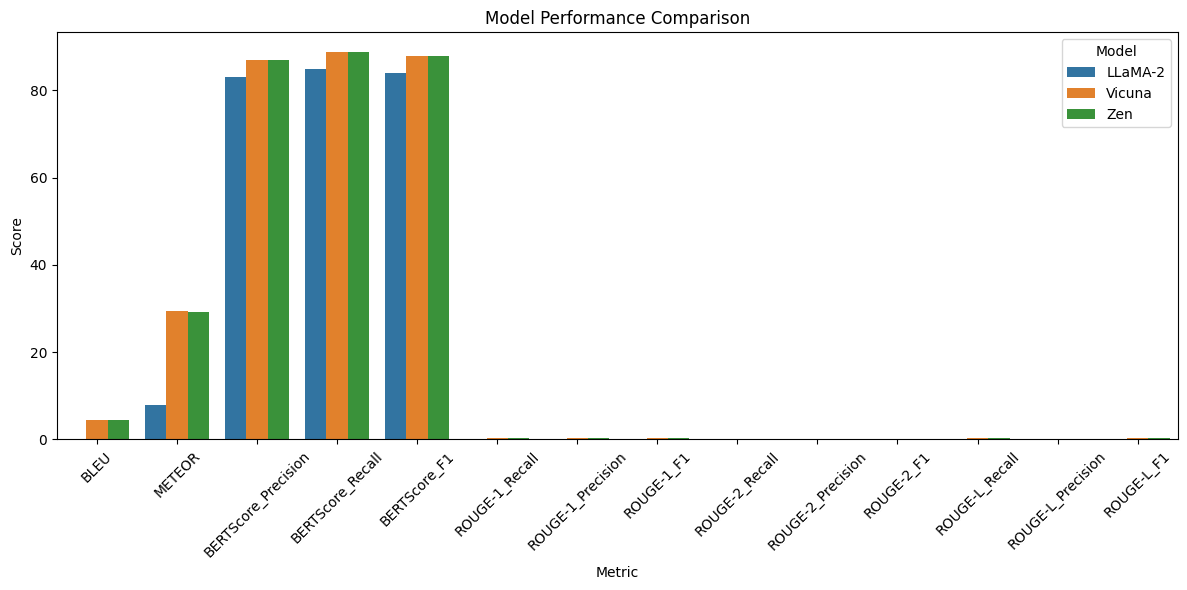

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

score_df = score_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=score_df)

# Customize the plot
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')

# Show the plot
plt.tight_layout()
plt.show()